# JAX demo: Can we fit a laser frequency comb?

Let's demo using JAX for blasé with HPF laser frequency comb data.  We'll also use exact Voigt profiles and introduce an instrument profile.

In [1]:
import matplotlib.pyplot as plt
from blase.utils import doppler_grid
import astropy.units as u
import numpy as np
from specutils import Spectrum1D

import jax.numpy as jnp

%matplotlib inline
%config InlineBackend.figure_format='retina'

`blasé` is much faster if you happen to have an NVIDIA® GPU.  Most consumer laptops don't have this hardware, but `cpu` codes will still work (just slower)!

### Set the wavelength limits

We will target a relatively narrow chunk of spectrum: $11000 - 11180$ Å.  We use a $60$ Å buffer to deal with edge effects.

In [2]:
wl_lo = 11_000-60
wl_hi = 11_180+60

## Read in an HPF LFC spectrum

In [3]:
from muler.hpf import HPFSpectrum

In [4]:
import numpy as np

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

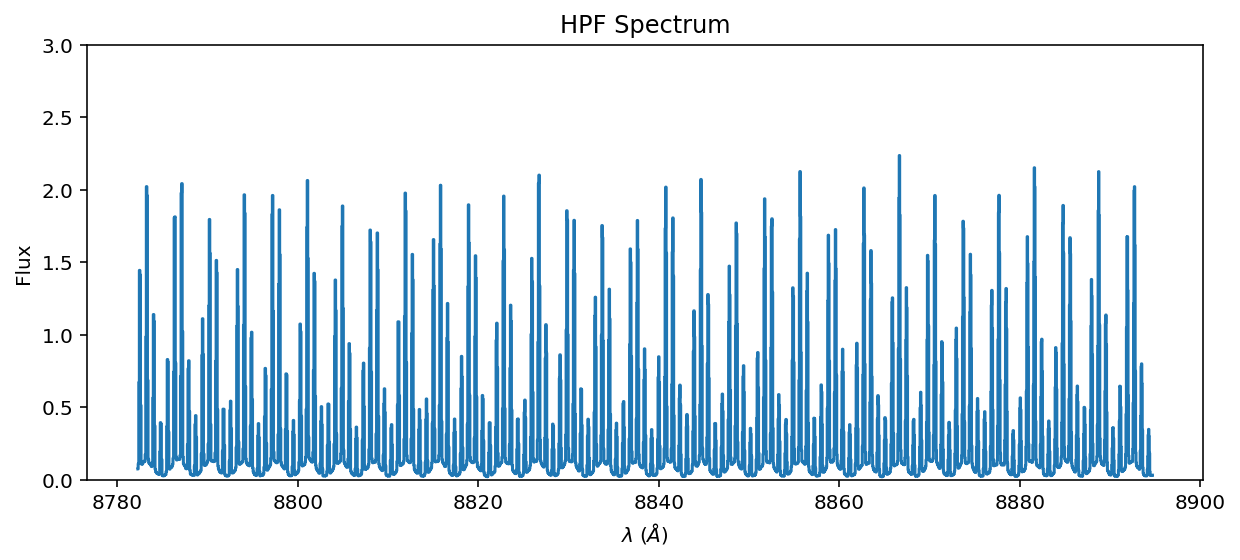

In [5]:
file = '/Volumes/pecos/HPF/TACC/CALS/CALS_Goldilocks_only/Goldilocks_20220623T082120_v1.0_0005.spectra.fits'
spec = HPFSpectrum(file=file, order=6)

spec = spec.lfc

spec = spec.trim_edges((10, 2040)).remove_nans().deblaze()
scalar = np.percentile(spec.flux, 90)
spec = spec.divide(scalar, handle_meta='ff')

spec.plot(ylo=0, yhi=3)

In [6]:
guess_sigma = 0.01
guess_gamma = 0.07

## Find the lines

In [7]:
from scipy.signal import find_peaks

In [8]:
peaks = find_peaks(spec.flux.value, distance=10, prominence=0.01)[0]

In [9]:
peak_coords = spec.wavelength.value[peaks]

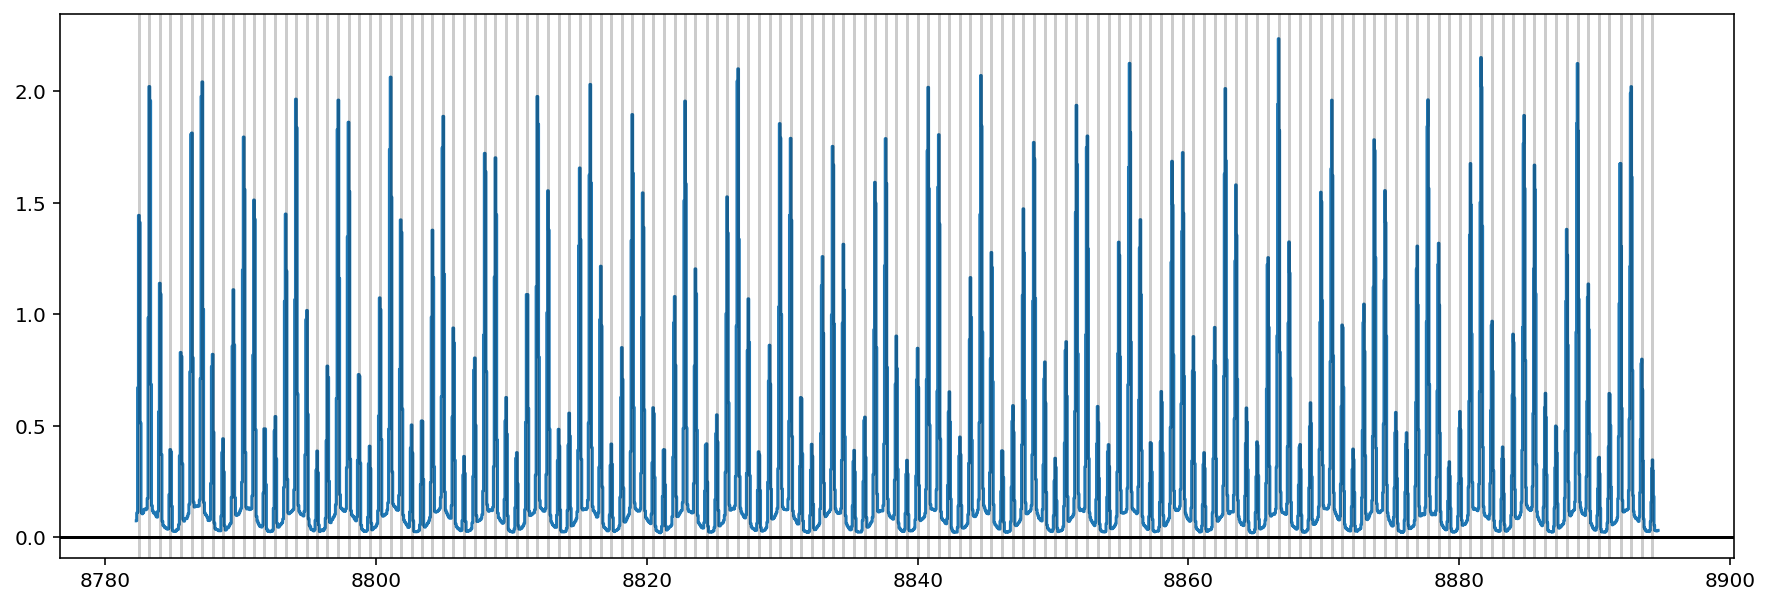

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.step(spec.wavelength, spec.flux, where='mid')

for xv in peak_coords:
    ax.axvline(xv, linestyle='solid', alpha=0.2, color='k')
    
ax.axhline(0.0, color='k');

In [11]:
wl_lo = spec.wavelength.min().value-30.0
wl_hi = spec.wavelength.max().value+30.0
wavelength_grid = jnp.array(doppler_grid(wl_lo, wl_hi))

## Make a sparse log emission emulator

In [12]:
from collections import OrderedDict

In [13]:
n_lines = len(peak_coords)

In [14]:
peak_coords = jnp.array(peak_coords)
guess_amps = 0.2*jnp.ones_like(peak_coords)

In [15]:
state_dict = OrderedDict({'lam_centers':peak_coords,
                  'amplitudes':jnp.log(guess_amps), 
                  'sigma_widths':jnp.log(jnp.repeat(guess_sigma, n_lines)), 
                  'gamma_widths':jnp.log(jnp.repeat(guess_gamma, n_lines)),
                  'a_coeff':jnp.array(1.0), 
                  'b_coeff':jnp.array(0.0),
                  'c_coeff':jnp.array(0.0), 
                  'radial_velocity':jnp.array(0.0)})

In [16]:
from blase.jaxemulator import SparseLinearEmissionEmulator

In [17]:
emission_model = SparseLinearEmissionEmulator(wavelength_grid, flux_native=jnp.zeros_like(wavelength_grid),
                                     init_state_dict=state_dict, wing_cut_pixels=100)

Initializing a sparse model with 144 spectral lines


In [18]:
pred = emission_model.forward(emission_model.amplitudes, 
                               emission_model.sigma_widths, 
                               emission_model.gamma_widths)

In [19]:
len(emission_model.sigma_widths)

144

In [20]:
wavelength_grid.shape, pred.shape

((11697,), (11697,))

In [21]:
pred.shape

(11697,)

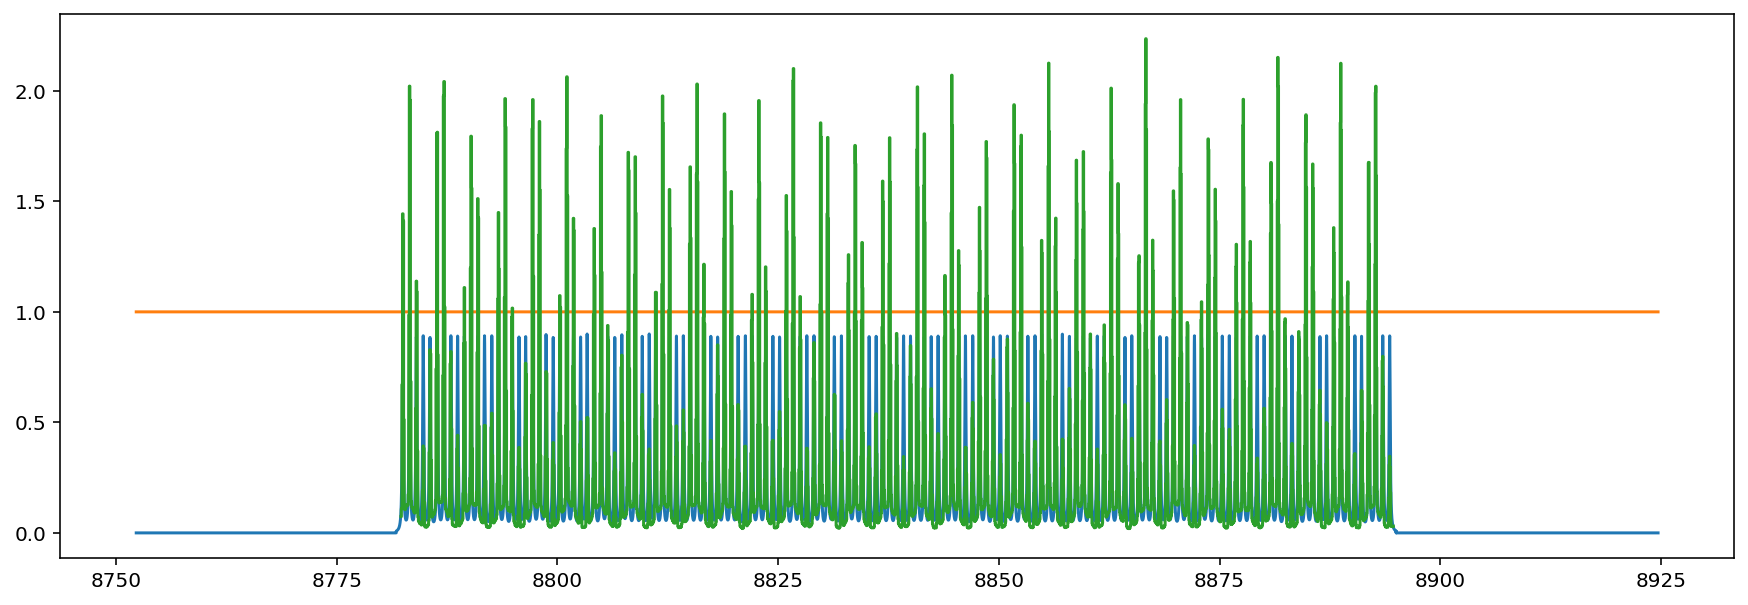

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(emission_model.wl_native, pred)
plt.plot(wavelength_grid, jnp.ones_like(wavelength_grid))

plt.step(spec.wavelength, spec.flux, where='mid')

Woohoo! It works!

(8825.0, 8829.0)

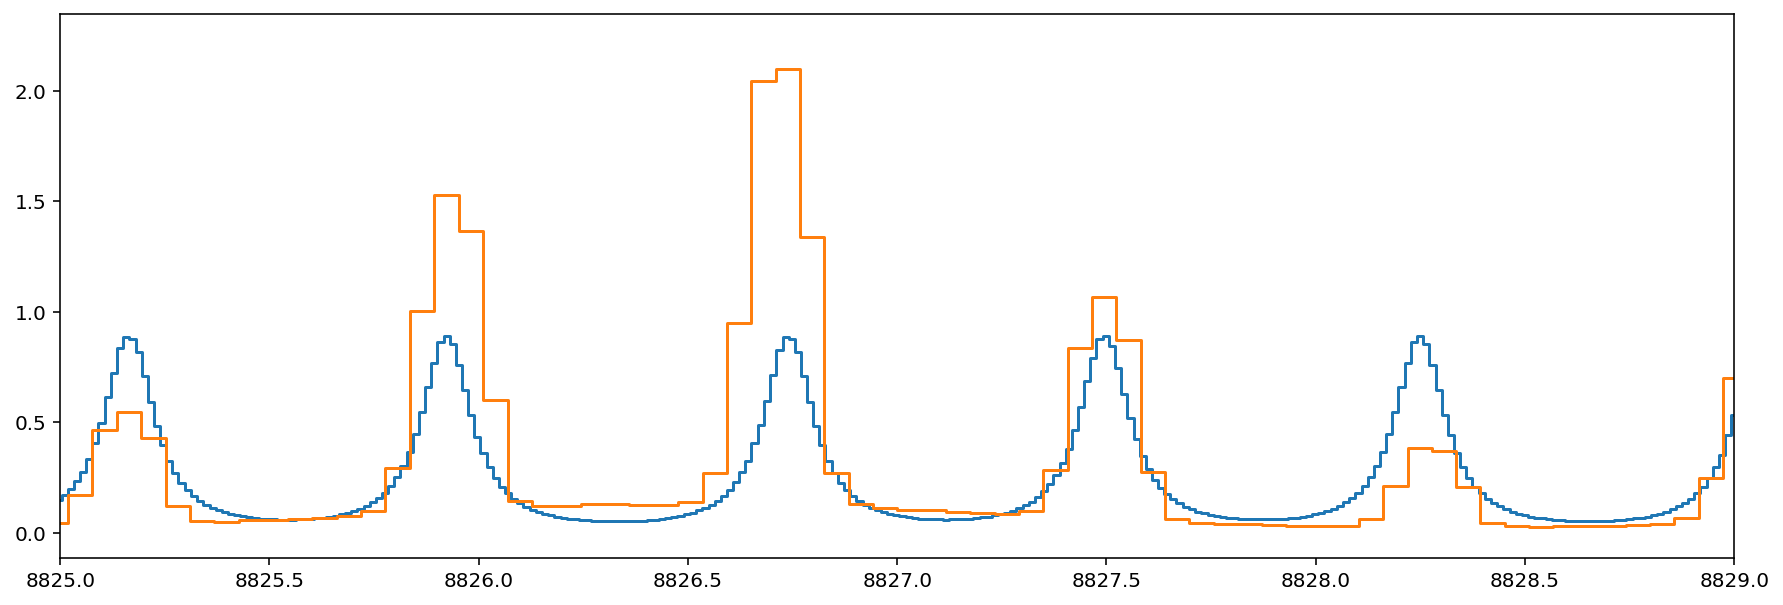

In [23]:
plt.figure(figsize=(15, 5))
plt.step(emission_model.wl_native, pred, where='mid')

plt.step(spec.wavelength, spec.flux, where='mid')
plt.xlim(8825, 8829)

We need an instrument model that sums the higher resolution model pixels within the bounds of the coarse data pixels.

In [24]:
flux_out = jnp.zeros_like(spec.flux.value)

In [25]:
jnp.array(spec.wavelength.bin_edges.value)

DeviceArray([8782.246, 8782.312, 8782.376, ..., 8894.623, 8894.669,
             8894.715], dtype=float32)

In [26]:
indices_hr = []
indices_lr = []
counts = []

In [27]:
for i in range(len(spec.wavelength)):
    l, r = spec.wavelength.bin_edges[i], spec.wavelength.bin_edges[i+1]
    index_vals = jnp.where( (wavelength_grid > l) & (wavelength_grid < r) )
    if index_vals is not None:
        indices_hr = indices_hr + [index_vals[0]]
        indices_lr = indices_lr + [i*jnp.ones_like(index_vals[0])]
        counts = counts + [len(index_vals[0])]

In [28]:
len(spec.wavelength)

2029

In [29]:
jnp.hstack(indices_hr).shape

(7485,)

In [30]:
flux_out = jnp.zeros_like(spec.wavelength)

In [31]:
indices_1d_hr = jnp.hstack(indices_hr)
indices_1d_lr = jnp.hstack(indices_lr)
counts = jnp.array(counts)

In [32]:
indices_1d = jnp.hstack(indices_hr)
vals = flux_out.at[indices_1d_lr].add(pred[indices_1d_hr])
binned_flux = vals/counts

In [33]:
def rebin_to_data(highres_model):
    '''The indices never change'''
    flux_out = jnp.zeros_like(spec.wavelength)
    vals = flux_out.at[indices_1d_lr].add(highres_model[indices_1d_hr])
    return vals/counts

(8825.0, 8829.0)

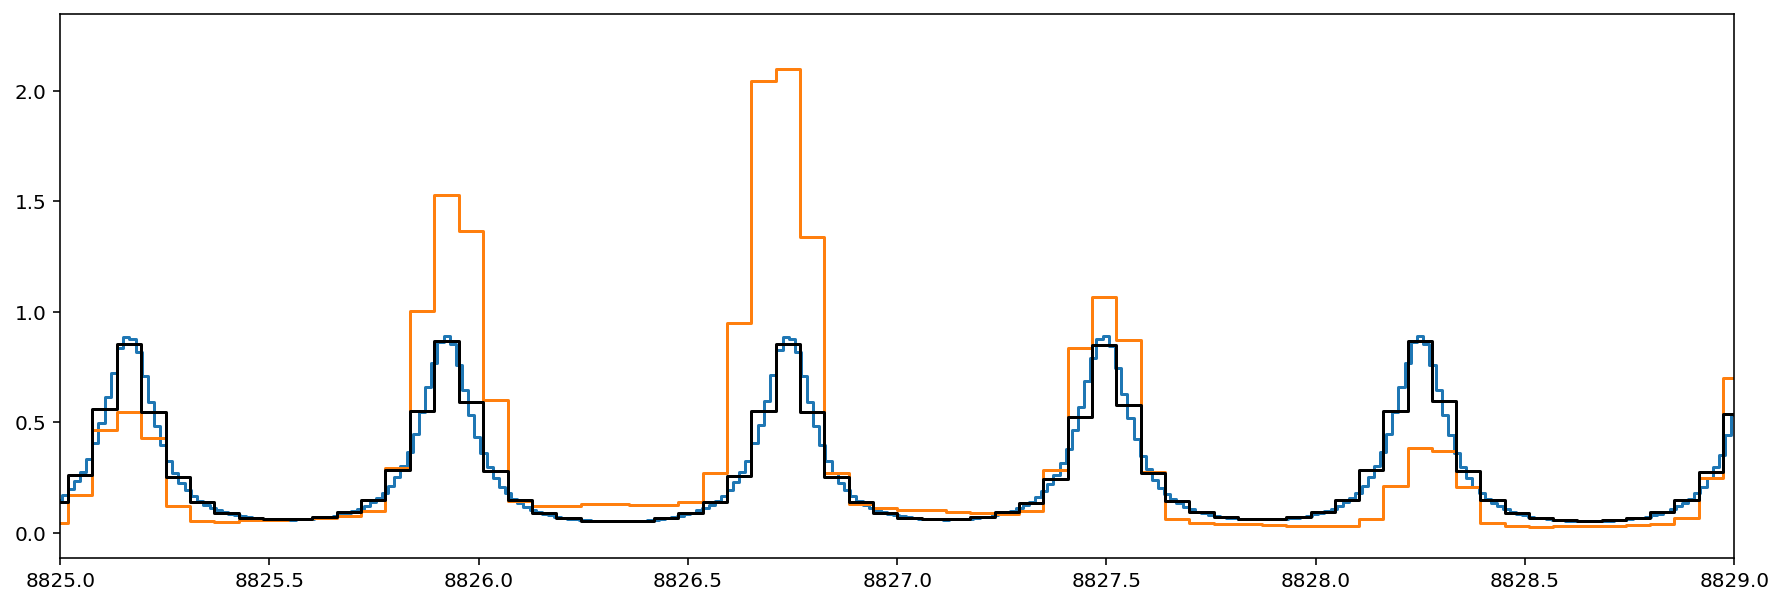

In [34]:
plt.figure(figsize=(15, 5))
plt.step(emission_model.wl_native, pred, where='mid')

plt.step(spec.wavelength, spec.flux, where='mid')

plt.step(spec.wavelength, binned_flux, where='mid', color='k')

plt.xlim(8825, 8829)

In [35]:
residual = spec.flux - binned_flux

## Optimize!

In [36]:
import optax
import jax

In [37]:
emission_model.active_mask.sum()

DeviceArray(3555, dtype=int32)

In [38]:
len(spec.wavelength)

2029

In [39]:
wl_active = jnp.array(spec.wavelength.value)
target = jnp.array(spec.flux.value)

We're not optimizing the wavelength center coordinates yet!  (We should though...)

In [40]:
initial_params = {
    'ln_amplitudes': emission_model.amplitudes,
    'ln_sigma_widths': emission_model.sigma_widths,
    'ln_gamma_widths': emission_model.gamma_widths,
}


def loss_mse(params: optax.Params):
    highres_model = emission_model.forward(params['ln_amplitudes'], params['ln_sigma_widths'], params['ln_gamma_widths'])
    y_hat = rebin_to_data(highres_model)
    loss_value = optax.l2_loss(y_hat, target).sum()
    return loss_value

In [41]:
loss = loss_mse

In [42]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state):
        loss_value, grads = jax.value_and_grad(loss)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i in range(2_000):
        params, opt_state, loss_value = step(params, opt_state)
        if i % 100 == 0:
            print(f'step {i}, loss: {loss_value}')

    return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=1e-3)
params = fit(initial_params, optimizer)

step 0, loss: 98.37777709960938
step 100, loss: 76.47087860107422
step 200, loss: 58.85893630981445
step 300, loss: 45.361785888671875
step 400, loss: 35.70053482055664
step 500, loss: 28.948352813720703
step 600, loss: 23.975189208984375
step 700, loss: 20.069007873535156
step 800, loss: 16.96562957763672
step 900, loss: 14.586108207702637
step 1000, loss: 12.868173599243164
step 1100, loss: 11.714338302612305
step 1200, loss: 10.991157531738281
step 1300, loss: 10.555398941040039
step 1400, loss: 10.28738784790039
step 1500, loss: 10.107744216918945
step 1600, loss: 9.973169326782227
step 1700, loss: 9.863302230834961
step 1800, loss: 9.769281387329102
step 1900, loss: 9.687105178833008


In [43]:
post_hr = emission_model.forward(params['ln_amplitudes'], 
                               params['ln_sigma_widths'], 
                               params['ln_gamma_widths'])

post = rebin_to_data(post_hr)

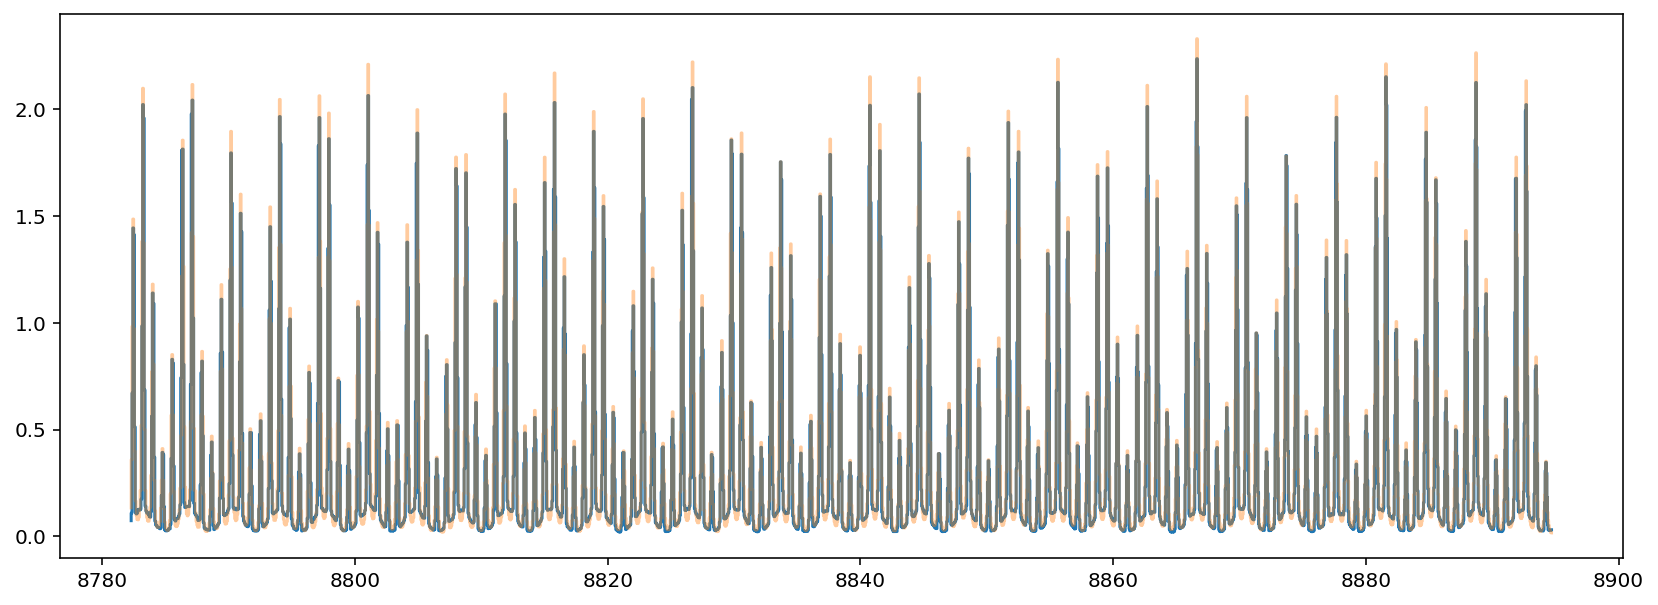

In [44]:
plt.figure(figsize=(14, 5))
plt.step(wl_active, target)

plt.step(wl_active, post, alpha=0.4)

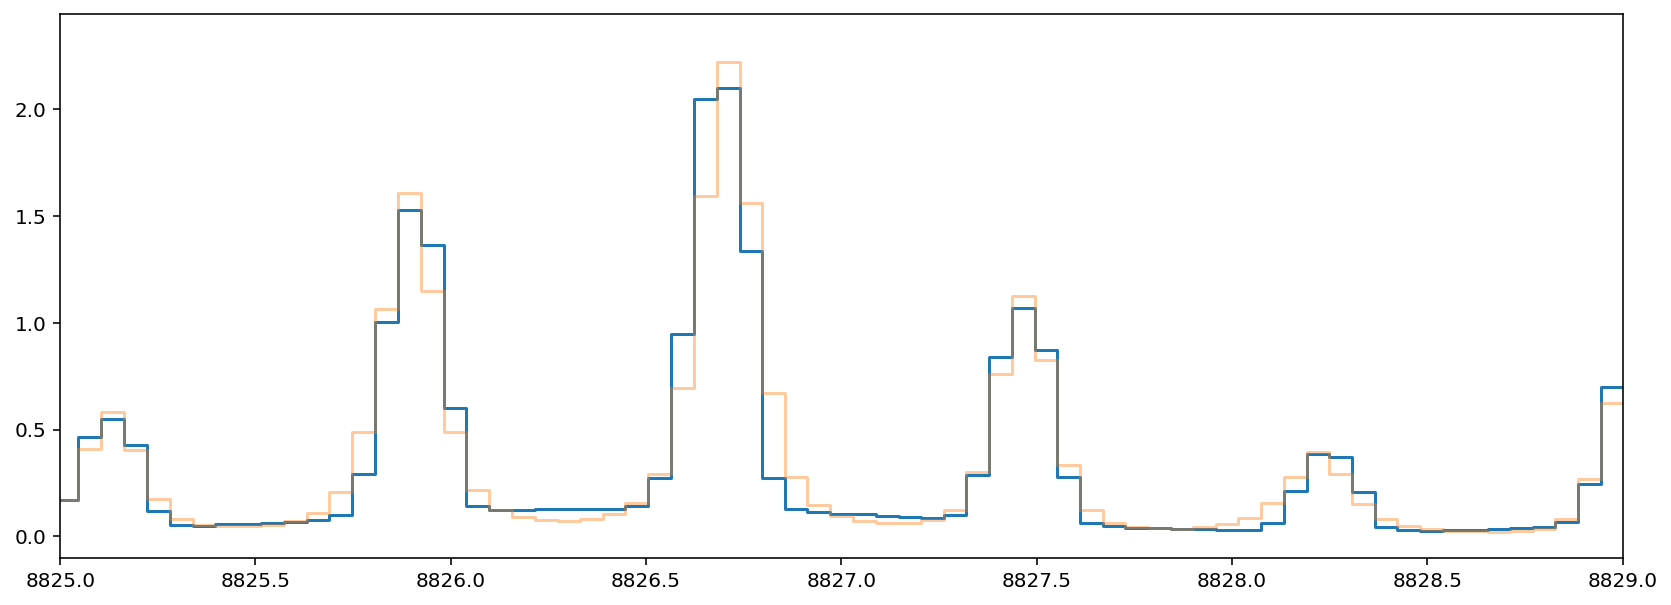

In [45]:
plt.figure(figsize=(14, 5))
plt.step(wl_active, target)

plt.step(wl_active, post, alpha=0.4)

plt.xlim(8825, 8829);

Hooray! We optimized the emission model of all spectral lines, with the rebinning instrument model!

### Stuff to do:

1. Tune the line center positions in the training step
2. Add a constant offset term
3. Convolve with an instrument profile
4. Fit with Gaussian Process regression (for the scattered-light looking sinusoidal signal, which does not get adequately fit by line wings alone).